# Analysing german news articles

## Imports

In [214]:
import pandas as pd
import os
from datetime import datetime 

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

from pytrends.request import TrendReq


## Load data into DataFrames

In [140]:
# Folderpath to CSV's
CSV_folderPath="/Users/jan/Documents/Python_Projects/Bachelorthesis/CSV_Backlog"

# Initialize list<csv> for Spiegel, Sueddeutsche, Bild and combined 
Spiegel_csvs = []
Sueddeutsche_csvs = []
Bild_csvs = []
Combi_csvs = []


# Change directory to CSV_folderPath
os.chdir(CSV_folderPath)

# iterate over all files
for file in os.listdir():
    # read csv to dataframe
    df =pd.read_csv(file, index_col=None, header=0)
    # all df append to combi...
    Combi_csvs.append(df)
    # sort dataframe to its list
    #Spiegel
    if file.startswith("Spiegel"):
        Spiegel_csvs.append(df)
    # Sueddeutsche
    elif file.startswith("Sueddeutsche"):
        Sueddeutsche_csvs.append(df)
    # Bild
    elif file.startswith("Bild"):
        Bild_csvs.append(df)
    
All_articles = pd.concat(Combi_csvs, axis=0, ignore_index=True)
Spiegel_articles = pd.concat(Spiegel_csvs, axis=0, ignore_index=True)
Sueddeutsche_articles = pd.concat(Sueddeutsche_csvs, axis=0, ignore_index=True)
if(len(Bild_csvs)) != 0:
    Bild_articles = pd.concat(Bild_csvs, axis=0, ignore_index=True)
else:
    Bild_articles=[]

    
# Drop duplicates

# All articles
All_articles= All_articles.drop_duplicates(subset="Titel")

# Spiegel articles
Spiegel_articles = Spiegel_articles.drop_duplicates(subset="Titel")

# Sueddeutsch articles
Sueddeutsche_articles = Sueddeutsche_articles.drop_duplicates(subset="Titel")

# Bild articles
#Bild_articles = Bild_articles.drop_duplicates(subset="title")
All_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16645 entries, 0 to 41555
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Titel                  16645 non-null  object 
 1   Date_Info              16645 non-null  object 
 2   URL                    16645 non-null  object 
 3   Overline               10049 non-null  object 
 4   Breadcrumb             7682 non-null   object 
 5   author                 1672 non-null   object 
 6   detailed_informations  2366 non-null   object 
 7   Zugriff_Datum          10345 non-null  float64
 8   News_page              16645 non-null  object 
 9   Unnamed: 0             0 non-null      object 
dtypes: float64(1), object(9)
memory usage: 1.4+ MB


## Data Cleaning

### Cast Date_Info to datetime

In [141]:



# All articles
All_articles["Date_Info"] = All_articles["Date_Info"].str.strip()
All_articles["Date_Info"] = pd.to_datetime(All_articles["Date_Info"], format='%d%m%Y_%H:%M')
# Spiegel articles
Spiegel_articles["Date_Info"] = Spiegel_articles["Date_Info"].str.strip()
Spiegel_articles["Date_Info"] = pd.to_datetime(Spiegel_articles["Date_Info"], format='%d%m%Y_%H:%M')
# Sueddeutsche articles
Sueddeutsche_articles["Date_Info"] = Sueddeutsche_articles["Date_Info"].str.strip()
Sueddeutsche_articles["Date_Info"] = pd.to_datetime(Sueddeutsche_articles["Date_Info"], format='%d%m%Y_%H:%M')
# Bild articles
#Bild_carticles["Date_Info"] = pd.to_datetime(Bild_carticles["Date_Info"], format='%d%m%Y_%H:%M')

   


## Initial data analysis

### Ammount of articles

In [142]:
# Spiegel articles
ammount_of_Spiegel_articles = len(Spiegel_articles)
print(f"Spiegel articles: {ammount_of_Spiegel_articles}")

# Sueddeutsche articles
ammount_of_Sueddeutsche_articles = len(Sueddeutsche_articles)
print(f"Sueddeutsche articles: {ammount_of_Sueddeutsche_articles}")

# Bild articles
ammount_of_Bild_articles = len(Bild_articles)
print(f"Bild articles: {ammount_of_Bild_articles}")

# All articles
ammount_of_Combined_articles = len(All_articles)
print(f"Overall: {ammount_of_Combined_articles}")

Spiegel articles: 6300
Sueddeutsche articles: 10346
Bild articles: 0
Overall: 16645


## Analysis

### Exploding titles

In [143]:
def explode_titles(title_column):
    title_column =title_column.to_frame()
    tokenized_titles=[]
    title_column["tokenized_title"] = ""
    for index, row in title_column.iterrows():
        # tokenize
        tokenized_title = word_tokenize(row.Titel)
        
        # remove stopwords & numbers/punction
        tokenized_title = [word for word in tokenized_title if word not in stopwords.words("german")]
        
        # add to row
        row.tokenized_title = tokenized_title
        
    return title_column
            
            

### Top titles

#### All titles

In [173]:
def get_occurence_of_all_titles(data_frame, columnName):
    # Group titles by columnName
    all_titles = data_frame.groupby(columnName).size()
    
    #sort titles
    all_titles = all_titles.sort_values(ascending = False)
    
    return all_titles

#### All capital titles

In [206]:
def get_occurence_of_all_capital_titles(data_frame, columnName):
    all_titles=data_frame.groupby(columnName).size()

    capital_titles=[]
    counter=0
    for title in all_titles.items():
        title_s=str(title)
        title_s=title_s.strip()
        if title_s.istitle():
            capital_titles.append(title)        
    Titles = pd.DataFrame.from_records(
    capital_titles, columns=['Title','Occurence'])
    sorted_Titles=Titles.sort_values(by=['Occurence'],ascending=False)

    return sorted_Titles
        
    

### Bar chart of title occurence

In [212]:
def occurence_of_titles(data_frame, columnName):
    # Group titles by columnName
    all_titles = data_frame.groupby(columnName).size()
    
    # sort titles
    all_titles = all_titles.sort_values(ascending = False)
    
    # return
    return all_titles

def get_N_of_titles(titles, N):
    x=0

def occurence_of_titles(data_frame, columnName, rangeToDisplay,capital, title):
    all_titles = occurence_of_titles(data_frame, column_Name)
    
    
    
    
def occurence_of_titles(data_frame, columnName, minOccurence_N,capital ,title):
    x=0
    
def occurence_of_titles(data_frame, columnName, rangeToDisplay ,minOccurence_N, capital, title):
    x=0

#### All  titles that occure more than N

In [208]:
def get_all_titles_occurence_N(data_frame, columnName, N):
    titles = get_occurence_titles(data_frame,columnName)
    
    

### Tokenize All_articles Title

In [144]:
All_articles["tokenized_titles"] = explode_titles(All_articles["Titel"]).tokenized_title

### Explode the titles

In [199]:
All_articles = All_articles.explode("tokenized_titles")

### Drop uninteresting titles

In [155]:
uninteresting_titles= ["Der", "Die", "Das","Was","Warum","Er","Sie", "Es", "Ich", "Du", "Mit","Wie","Ein","So","Wir",
                       ":","»","«", "," ,"\'\'","``", "_","-" ".","?","–", "-",".","!"]

All_articles=All_articles[~All_articles.tokenized_titles.isin(uninteresting_titles)]


## Connect to Google Trends

In [222]:
def google_interest_over_time(keyword_list, timeframe):
    # connect to google
    pytrends = TrendReq(hl='de-DE', tz=60) 

    # keywords
    keywords = keyword_list

    # build payload
    startDate = "2021-11-14"
    pytrends.build_payload(keywords, cat=0, timeframe= timeframe ) 

    # get data with interest over time
    data = pytrends.interest_over_time() 


## Plots

### Plot occurence of top 50 titles

<AxesSubplot:xlabel='tokenized_titles'>

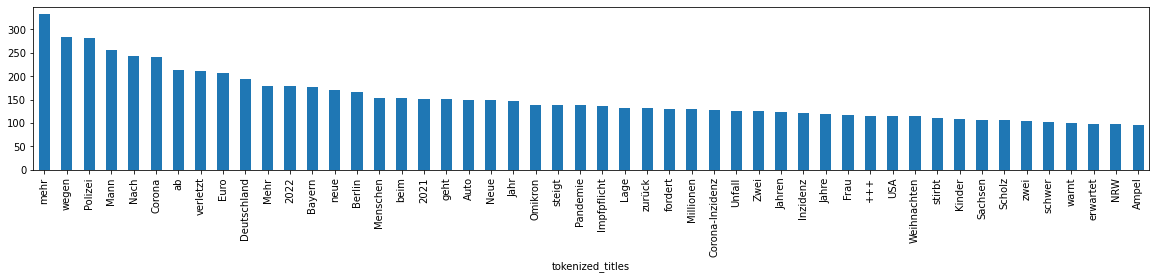

In [174]:
# get all titles
all_titles = get_occurence_of_all_titles(All_articles,"tokenized_titles")

# get top 50
top50_titles = all_titles[:50]

plt.figure(figsize=(20,3))
top50_titles.plot(kind="bar")

### Plot occurence of top 50 titles starting with capital letter

<AxesSubplot:xlabel='Title'>

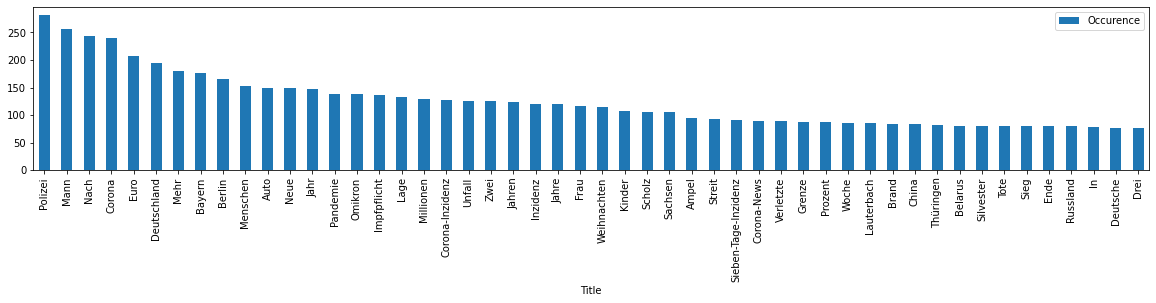

In [207]:
# get all titles
all_titles = get_occurence_of_all_capital_titles(All_articles,"tokenized_titles")

#get top 50
top50_titles = all_titles[:50]

#plot
top50.plot.bar(x="Title",y="Occurence",figsize=(20, 3))
